## A2C Pong Training fully Catogrical

#### A3C
[Mnih, Volodymyr, et al. "Asynchronous methods for deep reinforcement learning." International conference on machine learning. 2016.](http://proceedings.mlr.press/v48/mniha16.pdf)

### **Actor-Critic**

*Actor critic* method is one of the popular *policy optimization* algorithms. This approach maximizes the expected return by pushing up the probabilities of actions that receive higher returns. Let $\pi_\theta$ denote a policy with parameters $\theta$. The policy gradient of performance $\mathcal{J}(\pi_\theta)$ is

$$ \nabla_\theta \mathcal{J}(\pi_\theta) = \underset{\tau\sim\pi_\theta}{\mathbb{E}}\left[ \sum^T_{t=0} \nabla_\theta \log \pi_\theta(a_t|s_t)A^{\pi_\theta}(s_t, a_t) \right],$$

where $\tau$ is a trajectory and $A^{\pi_\theta}$ is the advantage function for reducing variance of values. The *policy gradient algorithm* updates the parameters by adding this gradient.

$$\theta_{k+1} = \theta_k + \alpha \nabla_\theta \mathcal{J}(\pi_{\theta_k}),$$

where $\alpha$ is a learning rate. The agent is trained in an on-policy way because the parameters are updated by the current policy. In this framework, the *Actor* predicts probabilities of actions for each state, and the *Critic* estimates the value function, which serves as a baseline to reduce the variance of the gradient updates.

#### **Critic Update**

The critic is trained to minimize the mean-squared error between the estimated value function $V(s_t; w)$ and the actual return or bootstrapped target:

$$ L(w) = \mathbb{E}\left[\left(R_t - V(s_t; w)\right)^2\right], $$

where $R_t$ is the return, which can include bootstrapping via a one-step TD target:

$$ R_t = r_t + \gamma V(s_{t+1}; w). $$

The gradient update for the critic is:

$$ w_{k+1} = w_k - \beta \nabla_w L(w_k), $$

where $\beta$ is the critic learning rate. In practice, this update is performed using backpropagation.

---

### **Combined Actor-Critic Training**
During training, the actor and critic are updated alternately for each collected trajectory:

1. **Actor Update**: 
   The policy is updated by increasing the likelihood of actions weighted by their advantages:

   $$ \nabla_\theta \mathcal{J}(\pi_\theta) = \sum_t \nabla_\theta \log \pi_\theta(a_t|s_t) A(s_t, a_t), $$

   where the advantage function $A(s_t, a_t)$ is typically approximated as:

   $$ A(s_t, a_t) = R_t - V(s_t; w). $$

2. **Critic Update**:
   The critic is updated to minimize the error in value prediction by adjusting $w$ using:

   $$ \nabla_w L(w) = \sum_t \nabla_w \left(R_t - V(s_t; w)\right)^2. $$

By alternately updating the actor and critic, the agent learns to improve both the policy and value estimation, leading to more stable and efficient training.

---

### **Entropy Regularization**
Entropy regularization is added to encourage exploration by discouraging premature convergence to deterministic policies. The entropy loss is given by:

$$ L_{\text{entropy}} = - \beta \sum_t \sum_a \pi_\theta(a|s_t) \log \pi_\theta(a|s_t), $$

where $\beta$ is the entropy coefficient. Higher $\beta$ encourages more exploration.

---

### **Overall Loss**
The combined loss for **Advantage Actor-Critic (A2C)** is the weighted sum of the policy loss, value function loss, and entropy loss:

$$ L = L_{\text{policy}} + c_1 L_{\text{value}} - c_2 L_{\text{entropy}}, $$

where $c_1$ and $c_2$ control the relative contribution of value and entropy losses. By balancing these terms, A2C ensures stable training and effective policy improvement.


#### Load dependencies for Env

In [1]:
import os
import datetime

import numpy as np 
import gymnasium as gym
import ale_py

try:
    from torch.utils.tensorboard import SummaryWriter
except ImportError:
    SummaryWriter = None  # type: ignore[misc, assignment]


gym.register_envs(ale_py)

env = gym.make('PongDeterministic-v4')
observation, info = env.reset()
print(observation.shape)
print(type(env.observation_space.shape))
print(env.action_space)

(210, 160, 3)
<class 'tuple'>
Discrete(6)


A.L.E: Arcade Learning Environment (version 0.10.1+6a7e0ae)
[Powered by Stella]


## Define Model, Optimizer, Loss with Torch


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

# Prioritize device: CUDA > MPS > CPU
if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
    print("CUDA is available. Using CUDA.")
elif torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
    print("MPS backend is available. Using MPS.")
else:
    DEVICE = torch.device("cpu")
    print("Neither CUDA nor MPS is available. Using CPU.")


class ActorCriticNet(nn.Module):

    def __init__(self, action_dim):
        """Initialize parameters and build model."""
        super(ActorCriticNet, self).__init__()

        # First we have same body for the actor and critic, in  our case 2 convolution layers network
        self.conv1 = nn.Conv2d(1, 32, kernel_size=8, stride=4) # 19x19x32 / params 8*8*1*32 = 2048
        # (80+2*0-8)/4 + 1 = 19
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, stride=2) # 8*8*64 / params 5*5*32*64 = 51200
        # (19 +2*0-5)/2 + 1 = 8
        self.size = 8*8*64
        self.feature_dim = 512
        
        # fully connected layer after convolutional layers  with 512 features
        self.fc1 = nn.Linear(self.size, self.feature_dim) # 8*8*64*512 = 2097152

        self.fc_action = nn.Linear(self.feature_dim, action_dim) # fully connected 
        self.fc_critic = nn.Linear(self.feature_dim, 1)

    def forward(self, state):
        """Forward method implementation."""
        x = F.relu(self.conv1(state))
        x = F.relu(self.conv2(x))

        x = x.view(-1, self.size)
        x = F.relu(self.fc1(x))

        logits = self.fc_action(x)
        distribution = Categorical(logits=logits)
        action = distribution.sample()
        log_prob = distribution.log_prob(action).unsqueeze(1)
        entropy = distribution.entropy().unsqueeze(1)
        value = self.fc_critic(x)

        return value, action.unsqueeze(1), log_prob, entropy 

MPS backend is available. Using MPS.


## Image Preprocessing

In [3]:
def preprocess(image):
    """ Pre-process 210x160x3 uint8 frame into 6400 (80x80) 1D float vector. """
    image = torch.Tensor(image).to(DEVICE) #converts to float 
    
    # Crop, downsample by factor of 2, and turn to grayscale by keeping only red channel
    image = image[35:195]
    image = image[::2,::2, 0]

    image[image == 144] = 0 # erase background (background type 1)
    image[image == 109] = 0 # erase background (background type 2)
    image[image != 0] = 1 # everything else (paddles, ball) just set to 1

    return image.unsqueeze(0).float() # (1,80,80)

def batch_preprocess(images):
    """ 
    Pre-process stacked images with shape [batch, stack, height, width, channels] into 
    preprocessed tensors and compute the difference between stacked frames.
    Usually shape will be like [batch, 2, 210, 160, 3] uint8 into [batch, 1, 80, 80] shape"""
    images = torch.Tensor(images).to(DEVICE) #converts to float 

    # add check in case we work with single env, where no batch axis/dim provided 
    if len(images.shape) < 5:
        images = images.unsqueeze(0) 
    
    # Crop, downsample by factor of 2, and turn to grayscale by keeping only red channel
    images = images[:, :, 35:195, :, :]
    images = images[:, :, ::2,::2, 0]

    # erase background (background type 1) and # erase background (background type 2)
    images = torch.where((images == 144) | (images == 109), torch.tensor(0.0, device=DEVICE), images)

    images = (images != 0).float() # everything else (paddles, ball) just set to 1

    # Compute difference between consecutive frames in the stack
    diff_images = images[:, 1] - images[:, 0]

    return diff_images.unsqueeze(1)

## Rollout Buffer/Storage

For $𝑛$ n-step Actor-Critic, the rollout storage collects and stores the following components for each step  $𝑡$ in a batch of $𝑁$ parallel environments:
- states/observations $S_{t}$
- value estimations $V(s_{t})$
- rewards $r_{t}$
- actions $a_{t}$
- action log probabilities $\log \pi(a_{t}|s_{t}, {\theta})$
- mask $m_{t}$ - a binary mask to indicate if the environment is still active (1 if active, 0 entered terminal state)

At each step $𝑡$, for environment $𝑏$, the collected data is:

$$ \{S_{t,b}, a_{t,b}, r_{t+1,b}, V(s_{t}), \log \pi(a_{t,b}|s_{t,b}, {\theta}), m_{t+1,b}  \} $$

This is collected iteratively for $n$ timesteps $N$ environments, then used for gradient updates in the Actor-Critic framework.
    
Additional important hyper parameters:
- number of steps $TD (n)$ error method 
- number of parallel environments executed 

---

#### **Generalized Advantage Estimation (GAE)**
To reduce variance further while balancing bias, **Generalized Advantage Estimation (GAE)** is often used. The advantage function is computed as a weighted sum of temporal difference (TD) residuals over multiple steps, controlled by a parameter $\lambda \in [0, 1]$:

$$ A(s_t, a_t) = \sum_{l=0}^\infty (\gamma \lambda)^l \delta_{t+l}, $$

where the TD residual $\delta_t$ is given by:

$$ \delta_t = r_t + \gamma V(s_{t+1}; w) - V(s_t; w). $$

This introduces a bias-variance tradeoff: lower $\lambda$ relies more on immediate TD errors (lower variance), while higher $\lambda$ uses longer-horizon rewards (lower bias).

\begin{align*}
\text{If }  \lambda=0,  \; \hat{A}_t^{\text{GAE}(\gamma,0)} & := \delta_t = r_t + \gamma V(s_{t+1}) - V(s_t) \\
\text{If }  \lambda=1,  \; \hat{A}_t^{\text{GAE}(\gamma,1)} & :=  \sum_{l=0}^{\infty} \gamma^{l} \delta_{t+l} = \sum_{l=0}^{\infty} \gamma^{l} r_{t+l} - V(s_t)
\end{align*}

---

In [4]:
import torch 
import numpy as np 

class RolloutStorage:
    """
    Rollout buffer used in on-policy algorithms like A2C/PPO.
    It corresponds to ``buffer_size`` transitions collected
    using the current policy or n-steps as we like to call it in TD.
    This experience will be discarded after the policy update.
    In order to use PPO objective, we also store the current value of each state
    and the log probability of each taken action.

    It is only involved in policy and value function training but not action selection.
    """
    def __init__(self, 
                 obs_shape: any,
                 action_space: any,
                 num_steps: int = 1, 
                 n_envs: int = 1,
                 device: torch.device = torch.device("cpu")):
        
        self.num_steps = num_steps
        self.n_envs = n_envs

        self.obs_shape = obs_shape
        self.action_space = action_space
        self.device = device

        self.last_obs = None # To store the last observation between rollouts

        if action_space.__class__.__name__ == 'Discrete' or action_space.__class__.__name__ == 'MultiDiscrete':
            self.action_dim = 1
        else:
            self.action_dim = action_space.shape[0]

        # setup all the data   
        self.reset()  
    
    def reset(self) -> None:
        """
        Call reset, whenever we starting to collect next n-step rollout of data. 
        """
        self.obs = torch.zeros(self.num_steps, self.n_envs, *self.obs_shape, dtype=torch.float32, device=self.device)
        self.rewards = torch.zeros(self.num_steps, self.n_envs, 1,  dtype=torch.float32, device=self.device)
        self.values = torch.zeros(self.num_steps, self.n_envs,  1,  dtype=torch.float32, device=self.device)
        self.log_probs = torch.zeros(self.num_steps, self.n_envs, 1, dtype=torch.float32, device=self.device)
        self.entropies =torch.zeros(self.num_steps, self.n_envs, 1, dtype=torch.float32, device=self.device)
        self.actions = torch.zeros(self.num_steps, self.n_envs, self.action_dim, dtype=torch.float32, device=self.device)
        self.masks = torch.ones(self.num_steps, self.n_envs, 1, dtype=torch.int8, device=self.device)
        self.advantages = torch.zeros(self.num_steps, self.n_envs, 1, dtype=torch.float32, device=self.device)
        self.returns = torch.zeros(self.num_steps, self.n_envs, 1, dtype=torch.float32, device=self.device)

        self.step = 0
    
    def add(
        self,
        obs: torch.Tensor,
        actions: torch.Tensor,
        log_probs: torch.Tensor,
        entropies: torch.Tensor,
        values: torch.Tensor,
        rewards: torch.Tensor,
        masks: torch.Tensor
    ) -> None:
        """
        :param obs: Observations
        :param action: Actions
        :param log_probs: log probability of the action
            following the current policy.
        :param values: estimated value of the current state
            following the current policy.
        :param entropies: entropy calculated for the current step
        :param rewards: rewards
        :param masks: indicate env is still active 
        """
        self.obs[self.step].copy_(obs)
        self.actions[self.step].copy_(actions)
        self.log_probs[self.step] = log_probs.clone() #keep gradients
        self.values[self.step] = values.clone() #keep gradients
        self.entropies[self.step] = entropies.clone() #keep gradients
        self.rewards[self.step].copy_(rewards)
        self.masks[self.step].copy_(masks)

        self.step = (self.step + 1) % self.num_steps # hopefully thios % is actually not needed here

    def compute_returns_and_advantages(
            self,
            last_values: torch.Tensor,
            gamma: float = 0.99,
            gae_lambda: float = 1.0) -> None:
        """
        Post-processing step: compute the advantages A using TD(n) error method, to use in the gradient calculation in future
            - TD(1) or A_1 is one-step estimate with bootstrapping delta_t = (r_{t+1} + gamma * v(s_{t+1}) - v(s_t))
            ....
            - TD(n) or A_n is n-step estimate with bootstrapping SUM_{l=0}^{n}(gamma^{l}*delta_{t+l})
               (r_{t+1} + gamma*r_{t+2} + gamma^2*r_{t+3} + .....+ gamma^(n+1)*v(s_{t+n+1}) - v(s_t))
        
        We using Generalized Advantage Estimation, in this case advantage calculated next way:

            - A_t^gae(gamma,lambda) = SUM_{l=0}^{\infty}( (gamma*lambda)^{l} * \delta_{t+l})

        :param last_values: state values estimation for the last step (one for each env)
        :param gamma: discount to be used in reward estimation
        :param use_gae:  use Generalized Advantage Estimation 
        :param gae_lambada: factor for trade off of bias vs variance for GAE
        """
        gae = 0
        for step in reversed(range(self.num_steps)):
            if step == self.num_steps - 1:
                next_values = last_values.detach()
            else:
                next_values = self.values[step+1].detach()
            delta = self.rewards[step] + gamma * self.masks[step] * next_values - self.values[step].detach() #td_error
            gae = delta + gamma * gae_lambda * self.masks[step] * gae
            self.advantages[step] = gae.detach()

        #R_t = A_t{GAE} + V(s_t) 
        self.returns = self.advantages + self.values.detach()
            

## A2C Agent 


In [ ]:
from collections import deque

class A2CAgent:
    """
    Advantage Actor Critic (A2C)
    :param env(gym.Env): The environment to learn from / openAI Gym environment - vector environment
    :param n_steps: The number of steps to run for each environment per update
        (i.e. batch size is n_steps * n_env where n_env is number of environment copies running in parallel)
    :param gamma: Discount factor
    :param gae_lambda: Factor for trade-off of bias vs variance for Generalized Advantage Estimator.
        Equivalent to classic advantage when set to 1.
    :param ent_coef: Entropy coefficient for the loss calculation
    :param vf_coef: Value function coefficient for the loss calculation
    :param gae_lambda: Factor for trade-off of bias vs variance for Generalized Advantage Estimator.
         Equivalent to classic advantage when set to 1.
    :param device: Device (cpu, cuda, ...) on which the code should be run.
    """
    def __init__(self,
                 env: gym.vector.VectorEnv,
                 n_steps: int = 5,
                 gamma: float = 0.99,
                 gae_lambda: float = 1.0,
                 ent_coef: float = 0.01,
                 min_ent_coef: float = 0.001,
                 lr: float = 1e-3,
                 vf_coef: float = 0.5,
                 device: torch.device = torch.device("cpu"),
                 save_path: str = 'a2c_pong'):
        
        self.env = env
        self.n_steps = n_steps
        self.n_envs = env.num_envs

        self.gamma = gamma
        self.gae_lambda = gae_lambda

        self.entropy_coef = ent_coef
        self.min_entropy_coef = min_ent_coef
        self.value_loss_coef = vf_coef
        self.device = device
        self.save_path = save_path

        # network and optimizer 
        action_space = self.env.action_space
        if isinstance(action_space, gym.spaces.MultiDiscrete):
            action_dims = action_space[0].n  # This gives the dimensions of first env, everywhere else same
        else: 
            action_dims = action_space.n
        self.actor_critic = ActorCriticNet(action_dims).to(self.device)
        self.optimizer = torch.optim.Adam(self.actor_critic.parameters(), lr=lr)

        # rollout storage
        self.rollout_storage =  RolloutStorage(
            (1, 80, 80), # this obs shape is diff of 2 processed frames 
            self.env.action_space, 
            num_steps=n_steps, 
            n_envs=self.n_envs, 
            device=self.device)

    def collect_rollouts(self):
        """
        Collect experiences using the current policy and fill a ``RolloutBuffer``.
        The term rollout here refers to the model-free notion and should not
        be used with the concept of rollout used in model-based RL or planning.
        """

        last_obs = self.rollout_storage.last_obs 
        self.rollout_storage.reset()

        for _ in range(self.n_steps):
            # with torch.no_grad():
            values, actions, log_probs, entropies =  self.actor_critic(last_obs)
            # print(action_log_probs)
            # print(values)
            # print(actions)

            # Take actions in env and look the results
            obs, rewards, terminates, truncates, infos = self.env.step(actions)

            # Updating global number of steps agent done, while learning
            self.num_timesteps += self.env.num_envs

            dones = (terminates | truncates)
            masks = torch.tensor(1 - dones, dtype=torch.float32).unsqueeze(-1)
            rewards = torch.tensor(rewards, dtype=torch.float32).unsqueeze(-1)

            maybeepinfo = infos.get('episode')
            if maybeepinfo:
                self._extract_episode_data(maybeepinfo, infos.get('_episode'))

            self.rollout_storage.add(last_obs, 
                            actions, 
                            log_probs,
                            entropies,
                            values,
                            rewards,
                            masks)
            
            last_obs = batch_preprocess(obs)

        # compute values for the last timestamp
        #with torhc.no_grad():
        last_values, _, _, _  = self.actor_critic(last_obs)

        self.rollout_storage.compute_returns_and_advantages(
            last_values, 
            self.gamma,
            self.gae_lambda)
        self.rollout_storage.last_obs = last_obs

    def learn(self):
        """
        Update policy using the currently gathered
        rollout buffer (one gradient step over whole data).
        
        We have same network for both actor(policy) and critic(value)

        For actor we calculate gradient accent to maximize accumulated n-step updates: action log probabilities * estimate of advantage function,
        where for last state one step update advantage function, for second last state two step update advantage function and so on 
          advantage = (r_{t+1} + gamma * v(s_{t+1}) - v(s_t))
        Additionally for actor we add entropy  dto favor exploration 

        For critic we calculate gradient decent to minimize mean squared error between estimated returns and value estimation for the state,
        where for last state one step return function, for second last state two step return function and so on 
          return = (r_{t+1} + gamma * v(s_{t+1}))
        """
        advantages = self.rollout_storage.advantages
        log_probs = self.rollout_storage.log_probs
        entropies = self.rollout_storage.entropies
        returns = self.rollout_storage.returns
        values = self.rollout_storage.values
        
        # 1. Policy gradient loss or Actor gradient loss (gradient only on the log probs) 
        #  here we have gradient accent, so added {-}
        policy_loss = -(advantages * log_probs).mean()

        # 2. Value loss using the TD(n) n step error  target  (gradient only on values)
        # here we have gradient decent, so keep it
        value_loss = F.mse_loss(values, returns)

        # 3. Entropy loss to favor exploration  (gradient on log probs)
        #  here we have gradient accent so added {-}
        entropy_loss = -torch.mean(entropies)
        
        # 4. Combine total loss for the network 
        loss = policy_loss + self.value_loss_coef * value_loss  +  self.entropy_coef * entropy_loss

        # 5. Optimization step
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        return loss, policy_loss, value_loss, entropy_loss

    def train(self, total_timesteps: int = 1e5, log_interval: int = 100):
        """Train the agent."""

        obs, _ = self.env.reset()
        self.rollout_storage.last_obs = batch_preprocess(obs)

        self.num_timesteps = 0
        self.episode_rewards = deque(maxlen=15)
        self.episode_lengths = deque(maxlen=15)
        # Calculate the updates
        update = 1

        while self.num_timesteps < total_timesteps:
            self.collect_rollouts()
            loss, policy_loss, value_loss, entropy_loss = self.learn()
            
             # Display training infos
            if update % log_interval == 0 and len(self.episode_rewards) > 1:
                print(
                    "Updates {}, num timesteps {}/{} Mean Length {:.1f}\n"
                    "Loss {:.4f}: Policy {:.4f} Value {:.4f} Entropy {:.4f}\n"
                    "Last {} training episodes: mean/median reward {:.1f}/{:.1f}, min/max reward {:.1f}/{:.1f}"
                    .format(
                        update, self.num_timesteps, total_timesteps, np.mean(self.episode_lengths),
                        loss, policy_loss, value_loss, entropy_loss,
                        len(self.episode_rewards), np.mean(self.episode_rewards),
                        np.median(self.episode_rewards), np.min(self.episode_rewards),
                        np.max(self.episode_rewards)
                    )
                )
                
                if self.entropy_coef != 0.0:
                    self.entropy_coef = max(self.min_entropy_coef, self.entropy_coef * 0.99) # 230 * 100 * 16 * 5 ~ 1.84 mln steps from 0.01 to 0.001
                
                if update % (10 * log_interval) == 0:
                    print('Saving checkpoint...')
                    torch.save(self.actor_critic.state_dict(), f'./models/checkpoint_{self.save_path}.pth')

                if  np.mean(self.episode_rewards) == 21:
                    print('Saving best solution, finishing training...')
                    torch.save(self.actor_critic.state_dict(), f'./models/checkpoint_{self.save_path}.pth')
                    break


            update += 1


    def _extract_episode_data(self, episode_data, episode_flags):
        """
        Extract data for environments where '_episode' is True and append it to 
        self.episode_info_buffer deque
            {'r': -21.0, '_r': True, 'l': 944, '_l': True, 't': 5.089006, '_t': True}- example
            r - cumulative reward
            l - episode length
            t - elapsed time since beginning of episode

        :param episode_data: dict, data from environments
        :param episode_flags: np.ndarray, boolean array indicating done environments
        """
        done_envs = np.where(episode_flags)[0]  # Get indices of done environments
    
        for env_index in done_envs:
            env_specific_data = {}
            for key, value in episode_data.items():
                if isinstance(value, np.ndarray):  # Ensure it's an array
                    env_specific_data[key] = value[env_index]
            self.episode_rewards.append(env_specific_data['r'])
            self.episode_lengths.append(env_specific_data['l'])

## Train and more

In [9]:
from gymnasium.wrappers import FrameStackObservation, RecordEpisodeStatistics
from gymnasium.vector import SyncVectorEnv


# Define a factory function for creating environments with wrappers
def make_env(env_id, num_stack):
    def _init():
        env = gym.make(env_id)
        # Wrap with RecordEpisodeStatistics
        env = RecordEpisodeStatistics(env)
        # Wrap with FrameStack
        env = FrameStackObservation(env, stack_size=num_stack)  
        return env
    return _init

# Create the vectorized environment
num_envs = 4
env_id = "PongDeterministic-v4"
stack_size = 2 # 2 frames

envs = SyncVectorEnv([make_env(env_id, 2) for _ in range(num_envs)])

agent = A2CAgent(envs, 
                 n_steps=128, 
                 gae_lambda=0.95, 
                 gamma=0.99,
                 ent_coef=0.01,
                 vf_coef=0.5,
                 device=DEVICE, 
                 lr=1e-3, 
                 save_path='a2c_categorical_gae_095_pong')
agent.train(total_timesteps=1e6, log_interval=10)

# RESULT 1  gae 1.0, gamma 0.99, ent_coef = 0.01, n_steps=5  66 min till 21/21 on 15 episodes
# RESULT 2  gae 0.96, gamma 0.99, ent_coef = 0.01, n_steps=5 57 min  till 21/21 on 15 episodes


Updates 10, num timesteps 5120/1000000.0 Mean Length 860.0
Loss -0.3697: Policy -0.4236 Value 0.1431 Entropy -1.7686
Last 4 training episodes: mean/median reward -20.8/-21.0, min/max reward -21.0/-20.0
Updates 20, num timesteps 10240/1000000.0 Mean Length 865.6
Loss 0.1341: Policy 0.0917 Value 0.1168 Entropy -1.6256
Last 9 training episodes: mean/median reward -20.7/-21.0, min/max reward -21.0/-20.0
Updates 30, num timesteps 15360/1000000.0 Mean Length 878.2
Loss 0.0646: Policy 0.0201 Value 0.1210 Entropy -1.6646
Last 15 training episodes: mean/median reward -20.7/-21.0, min/max reward -21.0/-20.0
Updates 40, num timesteps 20480/1000000.0 Mean Length 872.7
Loss -0.1316: Policy -0.1573 Value 0.0831 Entropy -1.6741
Last 15 training episodes: mean/median reward -20.6/-21.0, min/max reward -21.0/-20.0
Updates 50, num timesteps 25600/1000000.0 Mean Length 876.0
Loss -0.0055: Policy -0.0449 Value 0.1096 Entropy -1.6737
Last 15 training episodes: mean/median reward -20.5/-21.0, min/max reward

In [10]:
import os
import imageio
import numpy as np
from IPython.display import Video, display, HTML

def record_video(env, policy, out_directory, out_name, fps=60):
    """
    Generate a replay video of the agent and display it in the notebook.
    :param env: Environment to record.
    :param policy: Policy used to determine actions.
    :param out_directory: Path to save the video.
    :param fps: Frames per second.
    """
    images = []
    done = False
    obs, _ = env.reset()
    img = env.render()

    while not done:
        # Preprocess the observation, set input to network to be difference
        state = batch_preprocess(obs)

        # calculate actions and values
        value, action, action_prob, _ = policy(state)

        obs, reward, terminated, truncated, _ = env.step(action) 
        img = env.render()
        images.append(img)
        done = terminated or truncated
    
    # Save the video
    video_path = os.path.join(out_directory, out_name)
    imageio.mimsave(video_path, [np.array(img) for img in images], fps=fps)
    
    # Display the video in Jupyter notebook
    display(Video(video_path, embed=True, width=640, height=480))

In [12]:
env = gym.make('PongDeterministic-v4', render_mode='rgb_array')
env = FrameStackObservation(env, stack_size=2)

eval_model = ActorCriticNet(env.action_space.n).to(DEVICE)
eval_model.load_state_dict(torch.load('./models/checkpoint_a2c_categorical_gae_095_pong.pth'))
# Ensure the model is in evaluation mode
eval_model.eval()

record_video(env, eval_model, './videos', 'output_pong_a2c_categorical_pong.mp4')

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (160, 210) to (160, 224) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


<video width="640" height="480" controls>
  <source src="../assets/videos/output_pong_a2c_categorical_pong.mp4" type="video/mp4">
</video>


## OFFTOPIC 

torch.Size([4, 1, 80, 80])


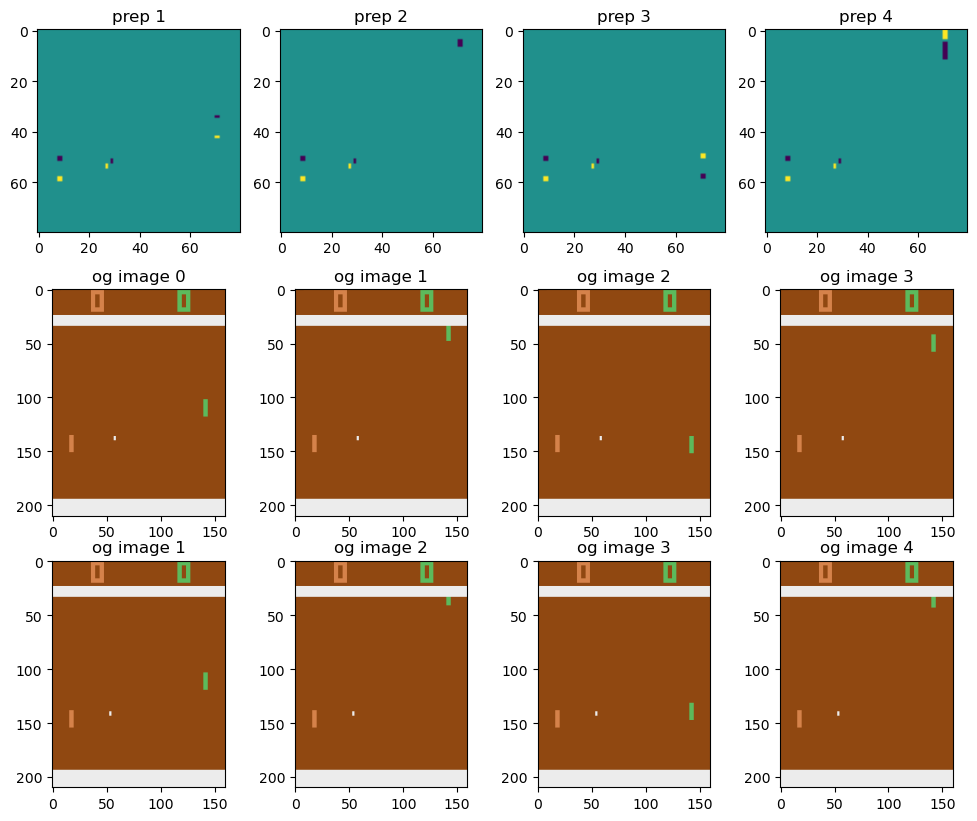

MultiDiscrete([6 6 6 6])
tensor([[0.0153],
        [0.0166],
        [0.0163],
        [0.0151]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[1],
        [1],
        [2],
        [3]], device='mps:0')
None
tensor([[-1.7938],
        [-1.7939],
        [-1.7802],
        [-1.7806]], device='mps:0', grad_fn=<UnsqueezeBackward0>)
tensor([[1.7917],
        [1.7917],
        [1.7917],
        [1.7916]], device='mps:0', grad_fn=<UnsqueezeBackward0>)
torch.Size([4, 1]) torch.Size([4, 1]) torch.Size([4, 1]) torch.Size([4, 1])
True
False
False
True
True
False


In [7]:
from gymnasium.wrappers import FrameStackObservation, RecordEpisodeStatistics
from gymnasium.vector import SyncVectorEnv


# Define a factory function for creating environments with wrappers
def make_env(env_id, num_stack):
    def _init():
        env = gym.make(env_id)
        # Wrap with RecordEpisodeStatistics
        env = RecordEpisodeStatistics(env)
        # Wrap with FrameStack
        env = FrameStackObservation(env, stack_size=num_stack)  
        return env
    return _init

# Create the vectorized environment
num_envs = 4
env_id = "PongDeterministic-v4"
stack_size = 2 # 2 frames

envs = SyncVectorEnv([make_env(env_id, 2) for _ in range(num_envs)])

import matplotlib
import matplotlib.pyplot as plt

envs.reset()
_, _, _, _, _= envs.step([0]*num_envs)
# get a frame after 20 steps - that's about the number needed to see the full screen with gameplay
for _ in range(20):
    frames, _, _, _, _ = envs.step(np.random.choice([2, 3], num_envs))

processed_frames = batch_preprocess(frames)
print(processed_frames.shape) 

plt.figure(figsize=(12, 10)) # 12 inches wide and 6 inch tall
for i in range(num_envs):
    plt.subplot(3,4,i+1)
    plt.imshow(processed_frames[i][0].cpu())
    plt.title(f'prep {i+1}')

    plt.subplot(3,4, i + 5)
    plt.imshow(frames[i][0])
    plt.title(f'og image {i}')

    plt.subplot(3,4, i + 9)
    plt.imshow(frames[i][1])
    plt.title(f'og image {i+1}')

plt.show()
print(envs.action_space)
model = ActorCriticNet(env.action_space.n).to(DEVICE)
value, action, log_prob, entropy  = model(processed_frames)
print(value)
print(value.grad_fn)
print(action)
print(action.grad_fn)
print(log_prob)
print(entropy)
print(value.shape, action.shape, log_prob.shape, entropy.shape)
rollouts = RolloutStorage((1,80,80), envs.action_space, 5, 4)
rollouts.add(processed_frames, action, log_prob, entropy, value, torch.Tensor([[0]]*4), torch.Tensor([[1]]*4))
print(rollouts.values[0].requires_grad)
print(rollouts.values[0].grad_fn)
print(rollouts.obs[0].requires_grad)
print(rollouts.actions[0].requires_grad)
print(rollouts.log_probs[0].requires_grad)
print(rollouts.entropies[0].requires_grad)
print(rollouts.rewards[0].requires_grad)